In [31]:
import numpy as np
import pandas as pd
import os
import glob
from scipy.io import wavfile
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import librosa
import librosa.display
## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style
from scipy.io import wavfile
import math, random
## This sets the plot style
## to have a grid on a white background
set_style("darkgrid")

In [32]:
##load audio data
data_dir = '../../data/raw_data/zenodo.4008297/'
data_fps = glob.glob(os.path.join(data_dir, '*'))


In [33]:
##load spectrogram data
X = np.load('../../data/processed_data/specgram_db_pad_trunc.npy')
## We need to reshape our data to be the correct dimensions for
## the net
## observations, grid, colorvalues

##so we just need to add the colorvalues, 1 here represents single valued
#X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
#print(X.shape)

df = pd.read_csv("../../data/processed_data/metadata.csv")
category_to_number = {'brushing': 0, 'food': 1, 'isolation': 2}

# Create a new column with numerical values based on the mapping
df['numerical_situation'] = df['situation'].map(category_to_number)

y = df['numerical_situation'].values

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                       test_size=.2,
                                                       shuffle=True,
                                                       random_state=100,
                                                       stratify=y)



reference on data augmentation: https://www.sciencedirect.com/science/article/pii/S1574954120300340

In [35]:
# ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
    
## I still have doubt about whether this is making the dataset to completely nonsense.
@staticmethod
def time_shift(aud, shift_limit):
    sig,sr = aud
    sig_len = sig.shape[0]
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (np.roll(sig,shift_amt), sr)

In [132]:
## add random noise
def random_noise(aud):
    sig,sr = aud
    noise_factor = max(original_audio)/30
    white_noise = np.random.randn(len(original_audio)) * noise_factor
    sig_noise = sig + white_noise
    return sig_noise,sr

In [87]:
##time stretch
def time_stretch(aud,strech):
    sig,sr = aud
    sig_len = sig.shape[0]
    stre_perc = strech*(2*np.random.rand()-1) # goes from -1 to 1
    
    strectch_t = librosa.core.resample(
        sig.astype(np.float32), 
        orig_sr=sr,
        target_sr=sr*(1+stre_perc))
    
    return (strectch_t,sr*(1+stre_perc))

In [38]:
# ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
    
@staticmethod
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    spec = torch.from_numpy(spec)
    n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
    
    
    return aug_spec.numpy()

/var/folders/2s/1wkfx2cd65169xd77m_hy0pm0000gq/T/ipykernel_63673/3530243818.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,original_audio = wavfile.read(samplefile)


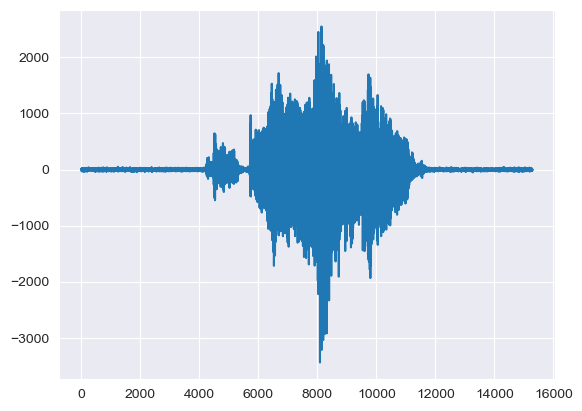

In [39]:
##let's check what each function do
# Look at just the first file

samplefile = data_fps[5]
sr,original_audio = wavfile.read(samplefile)
plt.plot(
    np.arange(original_audio.size),
    original_audio,
)



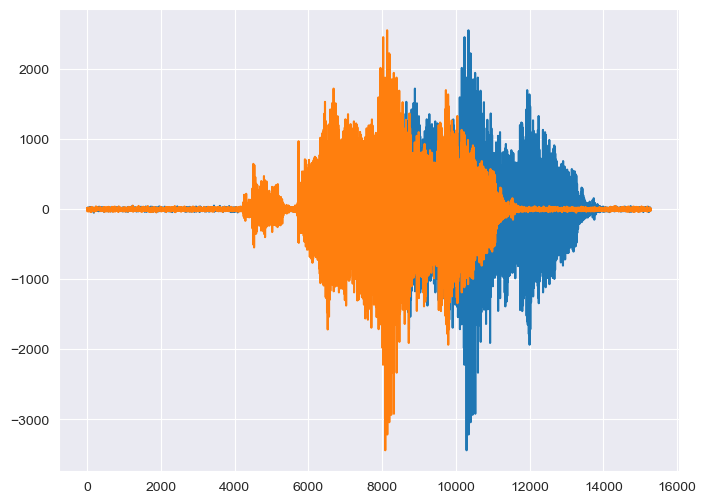

In [64]:
## time_shift
augmented_audio = time_shift((original_audio,sr), 0.2)
plt.figure(figsize = (8,6))
plt.plot(
    np.arange(augmented_audio[0].size),
    augmented_audio[0],
)

plt.plot(
    np.arange(original_audio.size),
    original_audio,
)


In [98]:
## time_strech
augmented_audio = time_stretch(((original_audio,sr)),0.3)
augmented_audio 

(array([  7.3675375 ,  11.486776  ,   0.22911035, ...,  -8.73943   ,
        -18.13135   ,   0.        ], dtype=float32),
 7269.879090880859)

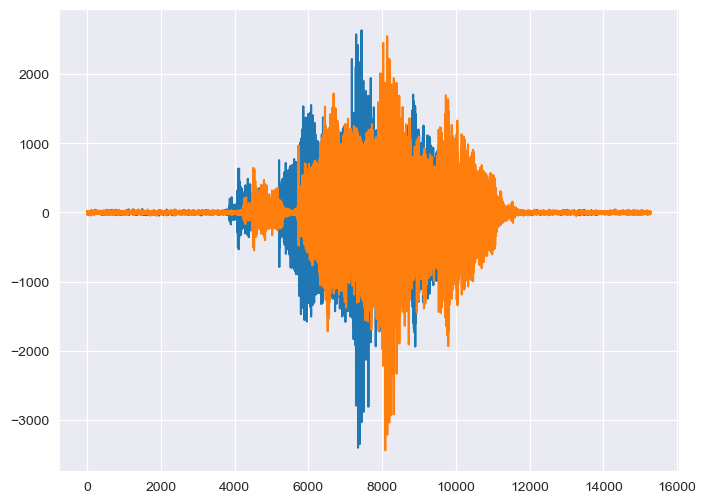

In [99]:
plt.figure(figsize = (8,6))
plt.plot(
    np.arange(augmented_audio[0].size),
    augmented_audio[0],
)

plt.plot(
    np.arange(original_audio.size),
    original_audio,
)


/var/folders/2s/1wkfx2cd65169xd77m_hy0pm0000gq/T/ipykernel_63673/3984018583.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,original_audio = wavfile.read(samplefile)


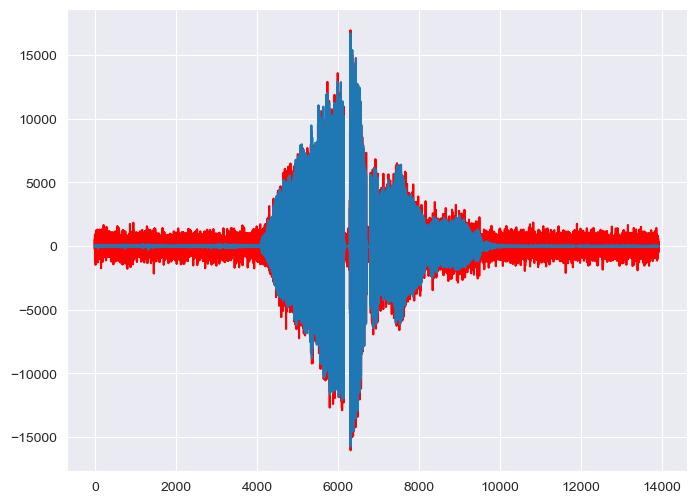

In [133]:
##random noise
samplefile = data_fps[100]
sr,original_audio = wavfile.read(samplefile)

aug_audio = random_noise((original_audio,sr))


plt.figure(figsize = (8,6))

plt.plot(
    np.arange(aug_audio[0].size),
    aug_audio[0],
    'r')

plt.plot(
    np.arange(original_audio.size),
    original_audio,
)



In [140]:
##check freq/time masking
spec_sample = X_train[5]
spec_aug = spectro_augment(spec_sample, max_mask_pct=0.08, n_freq_masks=2, n_time_masks=2)

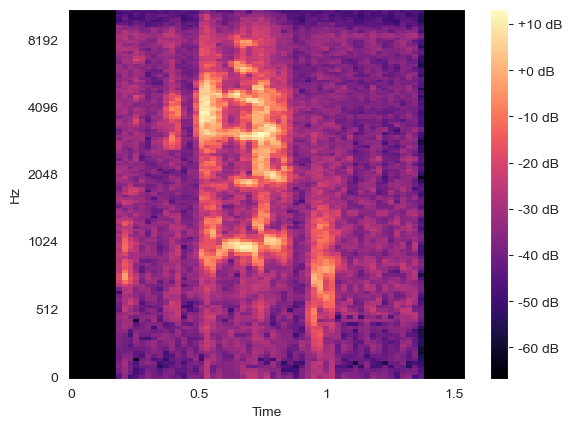

In [141]:
librosa.display.specshow(spec_sample, x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')

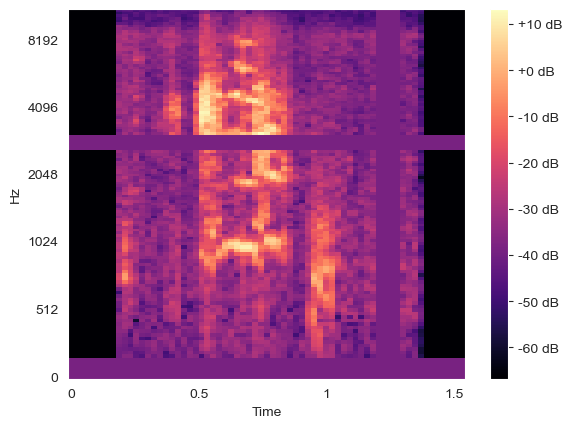

In [142]:
librosa.display.specshow(spec_aug, x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')